# Machine Learning Model Analysis

1. t-SNE (t-distributed stochastic neighbor embedding)
2. K means
3. RandomForest
4. XGBoost

### creating datatable to hold model outcomes

|Model||Unique Characteristics||Validation RMSE|
|---||---||---|
|baseline||no train/test/split||50|
|KNN||tuned neighbors(23)||47.25|
|neural network||untuned,basic||35|
|xgboost||no tuning, normalized, dropped features||34|
|xgboost||tuned,dropped fields,normalized||33|
|tsne xgboost||not tuned, tsne only||50.045862|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, normalize, Normalizer, PowerTransformer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

import warnings
warnings.simplefilter("ignore", UserWarning)

### Import preprocessed data

In [2]:
#import preprocessed data
train = pd.read_csv('train_preprocessed.csv')
test = pd.read_csv('test_preprocessed.csv')

# Unsupervised Learning Techniques

### t-SNE (t-distributed stochastic neighbor embedding)

There are 90 features in the dataset. A clustering algorithm was used to better understand the data.  It takes the high dimensionality of the dataset and reduces it for visualization, but still retains much of the original information.  This will help compare features across the 2D distribution.

Notes:
- learning rate
- n_iter_without_progress=200

In [29]:
#pull in categorical data prior to one-hot-encoding to use in 'hue' coloring in SNS graphs
orig_categorical = pd.read_csv('train_before_ohe.csv')
categorical_df = pd.DataFrame(orig_categorical[['Year_Factor','State_Factor', 'building_class', 'facility_type']])


def create_tsne():
    '''Create t-SNE model'''
    #scale the data
    sc = StandardScaler()
    scaled_tsne = sc.fit_transform(train)
    print('working on create_tsne now...')
    m = TSNE(perplexity=200, n_iter=250, early_exaggeration=12, verbose=0) 
    #fit/transform tsne model
    tsne_features = m.fit_transform(scaled_tsne)
    #features = tsne_features
    tsne_add_categorical(tsne_features)
    #return tsne_features and get reduction size
    print(tsne_features.shape)
    
def tsne_add_categorical(features):    
    '''add categorical data to the tsne features created in function create_tsne'''
    # add categorical data to tsne data
    #features = create_tsne(tsne_features)
    tsne_df = pd.DataFrame(features,columns=['feature_1','feature_2']) #call other function here
    tsne_all = tsne_df.join(categorical_df)
    #data = tsne_all
    tsne_graph(tsne_all) #was data
    print('completed tsne_add_categorical function...')
    

def tsne_graph(data):
    '''create seaborn joint plot of the t-SNE results and overlay categorical data as hue'''
    sns.jointplot(data=data,x='feature_1', y='feature_2', hue='State_Factor',height=10)

working on create_tsne now...
[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 75747 samples in 0.009s...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 75747 samples in 118.847s...
[t-SNE] Computed conditional probabilities for sample 1000 / 75747
[t-SNE] Computed conditional probabilities for sample 2000 / 75747
[t-SNE] Computed conditional probabilities for sample 3000 / 75747
[t-SNE] Computed conditional probabilities for sample 4000 / 75747
[t-SNE] Computed conditional probabilities for sample 5000 / 75747
[t-SNE] Computed conditional probabilities for sample 6000 / 75747
[t-SNE] Computed conditional probabilities for sample 7000 / 75747
[t-SNE] Computed conditional probabilities for sample 8000 / 75747
[t-SNE] Computed conditional probabilities for sample 9000 / 75747
[t-SNE] Computed conditional probabilities for sample 10000 / 75747
[t-SNE] Computed conditional probabilities for sample 11000 / 75747
[t-SNE] Computed conditional probabilities for sample 12000 / 75747
[t-SNE] Computed conditional probabilities for sample 13000 / 75747
[t-SNE] Computed conditional probabilities for sample 14000 / 757

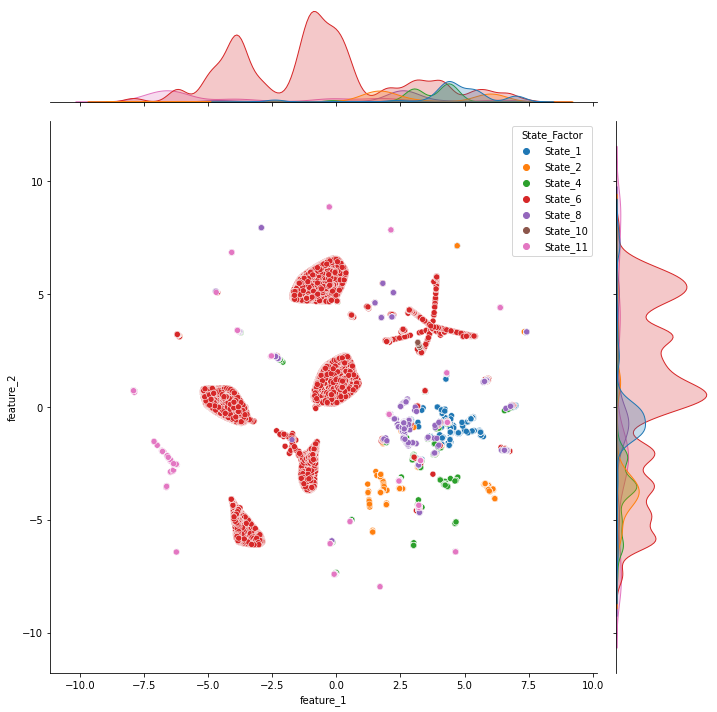

In [30]:
create_tsne()

In [17]:
#scale the data
sc = StandardScaler()
scaled_tsne = sc.fit_transform(train)
#instantiate
m = TSNE(perplexity=400, n_iter=3000, early_exaggeration=12, verbose=3) #learning_rate default is 200 range [10-1000]
#fit/transform tsne model on data set, what size did it reduce to?
tsne_features = m.fit_transform(scaled_tsne)
print(tsne_features.shape)

#[t-SNE] KL divergence after 3000 iterations: 0.546300


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 1201 nearest neighbors...
[t-SNE] Indexed 75747 samples in 0.010s...
[t-SNE] Computed neighbors for 75747 samples in 113.805s...
[t-SNE] Computed conditional probabilities for sample 1000 / 75747
[t-SNE] Computed conditional probabilities for sample 2000 / 75747
[t-SNE] Computed conditional probabilities for sample 3000 / 75747
[t-SNE] Computed conditional probabilities for sample 4000 / 75747
[t-SNE] Computed conditional probabilities for sample 5000 / 75747
[t-SNE] Computed conditional probabilities for sample 6000 / 75747
[t-SNE] Computed conditional probabilities for sample 7000 / 75747
[t-SNE] Computed conditional probabilities for sample 8000 / 75747
[t-SNE] Computed conditional probabilities for sample 9000 / 75747
[t-SNE] Computed conditional probabilities for sample 10000 / 75747
[t-SNE] Computed conditional probabilities for sample 11000 / 75747
[t-SNE] Computed conditional probabilities for sample 12000 / 75747
[t-SNE] Computed conditional probabilities for

[t-SNE] Iteration 1500: error = 0.6496294, gradient norm = 0.0000257 (50 iterations in 59.931s)
[t-SNE] Iteration 1550: error = 0.6416594, gradient norm = 0.0000243 (50 iterations in 59.174s)
[t-SNE] Iteration 1600: error = 0.6342795, gradient norm = 0.0000230 (50 iterations in 60.116s)
[t-SNE] Iteration 1650: error = 0.6274696, gradient norm = 0.0000217 (50 iterations in 62.056s)
[t-SNE] Iteration 1700: error = 0.6211849, gradient norm = 0.0000209 (50 iterations in 59.199s)
[t-SNE] Iteration 1750: error = 0.6152574, gradient norm = 0.0000201 (50 iterations in 59.351s)
[t-SNE] Iteration 1800: error = 0.6097831, gradient norm = 0.0000192 (50 iterations in 58.906s)
[t-SNE] Iteration 1850: error = 0.6046296, gradient norm = 0.0000182 (50 iterations in 59.126s)
[t-SNE] Iteration 1900: error = 0.5998892, gradient norm = 0.0000175 (50 iterations in 59.576s)
[t-SNE] Iteration 1950: error = 0.5955048, gradient norm = 0.0000166 (50 iterations in 59.332s)
[t-SNE] Iteration 2000: error = 0.591337

In [21]:
# add categorical data to tsne data
orig_categorical = pd.read_csv('train_before_ohe.csv')
categorical_df = pd.DataFrame(orig_categorical[['Year_Factor','State_Factor', 'building_class', 'facility_type']])

tsne_df = pd.DataFrame(tsne_features,columns=['feature_1','feature_2'])
tsne_all = tsne_df.join(cat_df)
tsne_all


,feature_1,feature_2,Year_Factor,State_Factor,building_class,facility_type
0,10.756618,31.296217,1,State_1,Commercial,Grocery_store_or_food_market
1,-20.284163,51.414463,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center
2,3.113768,22.626421,1,State_1,Commercial,Retail_Enclosed_mall
3,-1.001320,53.320328,1,State_1,Commercial,Education_Other_classroom
4,7.336008,39.468544,1,State_1,Commercial,Warehouse_Nonrefrigerated
...,...,...,...,...,...,...
75742,31.920099,67.863808,6,State_11,Commercial,Office_Uncategorized
75743,99.953308,-11.541988,6,State_11,Residential,5plus_Unit_Building
75744,1.383313,70.507027,6,State_11,Commercial,Commercial_Other
75745,0.663923,69.219719,6,State_11,Commercial,Commercial_Other


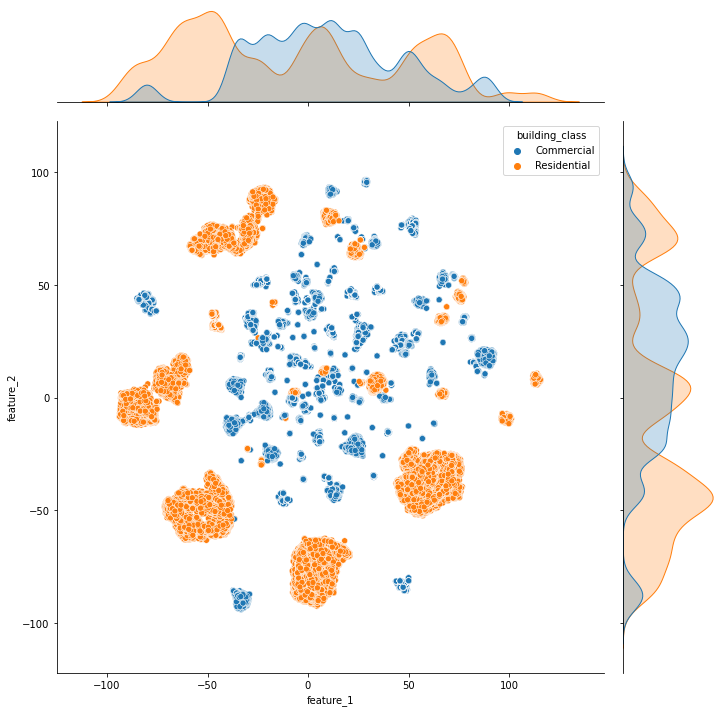

In [23]:
sns.jointplot(data=tsne_all,x="feature_1", y="feature_2", hue='building_class',height=10)

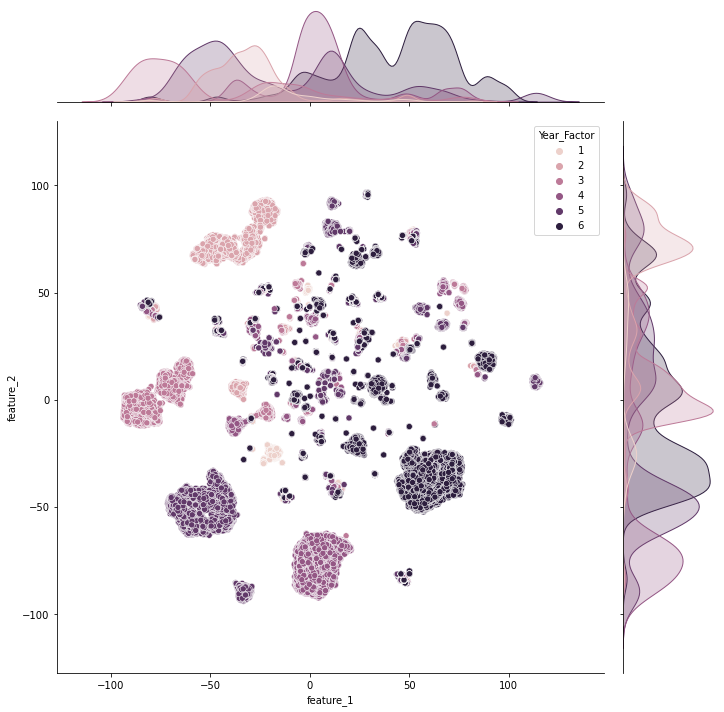

In [24]:
building = sns.jointplot(data=tsne_all,x="feature_1", y="feature_2", hue='Year_Factor',height=10)

## KMeans

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [18]:
X = train.drop(['site_eui'],axis=1)
y = train['site_eui']

In [25]:

def kmeans_pca():
    X = train.drop(['site_eui'],axis=1)
    y = train['site_eui']
    #scale data
    
    sc = StandardScaler()
    X = sc.fit_transform(X)
    #kmeans
    kmeans = KMeans(n_clusters=5,random_state=44)
    kmeans = kmeans.fit(X)
    kmeans.labels_
    # "predictions" for new data
    predictions = kmeans.predict(X)
    # calculating the Counts of the cluster
    unique, counts = np.unique(predictions, return_counts=True)
    counts = counts.reshape(1,5)
    # Creating a dataframe
    countscldf = pd.DataFrame(counts, columns = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"])
    # display
    countscldf
    
    y_num = predictions
    
    target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]

    pca = PCA(n_components=2, random_state = 453)
    X_pca = pca.fit(X).transform(X)
    
    # Percentage of variance explained for each components
    print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

    # Plotting the data
    plt.figure()
    plt.figure(figsize=(12,8))
    colors = ['navy', 'turquoise', 'darkorange', 'red', 'black']
    lw = 2


    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
        plt.scatter(X_pca[y_num == i, 0], X_pca[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
    plt.title('PCA of 2 Items')
    plt.show()

Explained variance ratio (first two components): [0.11536954 0.07809309]


<Figure size 432x288 with 0 Axes>

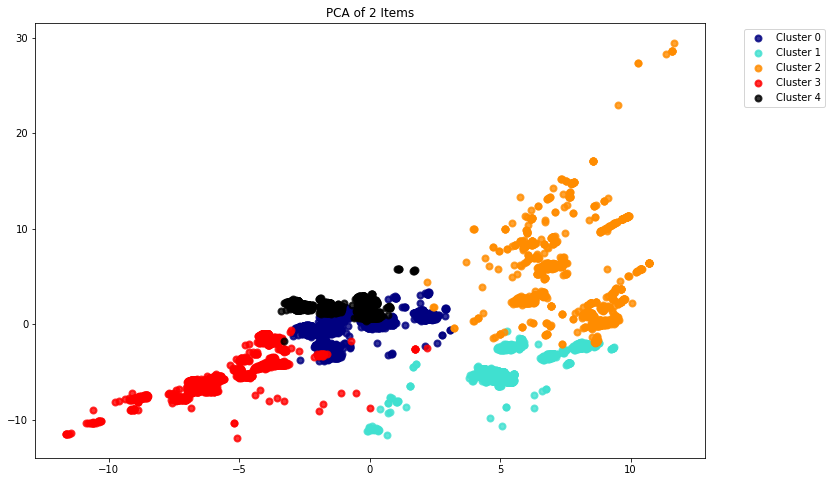

In [26]:
kmeans_pca()

### determine how many components needed in pca

In [ ]:
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('reducer',PCA(n_components=0.80))]) #set explained variance threshold as value rather than count

pc = pipe.fit_transform(X_sc)

#fit the pipe to the data
pipe.fit(X_sc)
print(len(pipe.steps[1][1].components_)) #number of features resulting

# Supervised Learning Methods

## Random Forest Regressor

In [33]:
#create model dataset

#scale data
X = train.drop(['site_eui'],axis=1)
X_norm = normalize(X,axis=0)
y = train['site_eui']

X_train,X_test,y_train,y_test = train_test_split(X_norm,y,test_size=0.3,random_state=44)

In [48]:
def random_forest_regressor(X_train,X_test,y_train,y_test):
    # Hyper parameters range intialization for tuning 
    param_dict = {"max_depth": [40,50],
                  "min_samples_leaf": [0.001],
                  "max_features": [50,60],
                  "random_state":[44],
                  "max_leaf_nodes":[400,500,800],
                  "min_impurity_decrease":[0.0]}

    #regressor
    rf = RandomForestRegressor()

    grid_rf = GridSearchCV(rf,
                     param_grid=param_dict, 
                     cv=4,
                     scoring ="neg_root_mean_squared_error",
                     n_jobs=-1,
                    verbose=3)

    #scoring='neg_mean_squared_error'
    grid_rf.fit(X_train,y_train)

    best_params = grid_rf.best_params_
    best_rmse = abs(grid_rf.best_score_)

    # Print the tuned parameters and score
    print(f'Tuned Random Forest Parameters: {best_params}')
    print(f'Best Random Forest RMSE: {best_rmse}')
    
    #test for over or underfitting - this .score might not work it's for classifiers
    print(grid_rf.score(X_test,y_test))
    print(grid_rf.score(X_train,y_train))

In [49]:
random_forest_regressor(X_train,X_test,y_train,y_test)


Fitting 4 folds for each of 6 candidates, totalling 24 fits
Tuned Random Forest Parameters: {'max_depth': 40, 'max_features': 50, 'max_leaf_nodes': 500, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'random_state': 44}
Best Random Forest RMSE: 45.34204336976669
-47.932059700272355
-44.143021314765164


RESULTS
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Tuned Random Forest Parameters: {'max_depth': 40, 'max_features': 50, 'max_leaf_nodes': 500, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'random_state': 44}
Best Random Forest RMSE: 45.34204336976669
-47.932059700272355
-44.143021314765164


Fitting 4 folds for each of 12 candidates, totalling 48 fits
Tuned Random Forest Parameters: {'max_depth': 40, 'max_features': 50, 'max_leaf_nodes': 400, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'random_state': 44}
Best Random Forest RMSE: 45.343045205469856





## pipeline trying

#### Note: This function captures the pipeline and grid search, but due to the minimal computational power of my computer I will do a simplified gridsearch outside of this function to narrow down the best parameters.

In [46]:
X = train.drop(['site_eui'],axis=1)
y = train['site_eui']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=44)

def supervised_analysis(model):
    pipe = Pipeline([
        ('scaler',StandardScaler()),
        ('reducer',PCA(n_components=0.80)), #set explained variance threshold as value rather than count
        ('regressor',model)]) 

    pipe.fit(X_train, y_train)

    parameters = {"regressor__max_depth": [20],
                  "regressor__min_samples_leaf": [0.001],
                  "regressor__max_features": [30],
                  "regressor__random_state":[44],
                  "regressor__max_leaf_nodes":[500],
                  "regressor__min_impurity_decrease":[0.0]
                }

#     #KNeighborsRegressor settings
#     parameters = {"regressor__n_neighbors": [19]}    
    
#     #RandomForest settings
#     parameters = {"regressor__max_depth": [20],
#               "regressor__min_samples_leaf": [0.001],
#               "regressor__max_features": [30],
#               "regressor__random_state":[44],
#               "regressor__max_leaf_nodes":[500],
#               "regressor__min_impurity_decrease":[0.0]}

    #XGBoost settings
#   parameters = {"regressor__max_depth": [20],
#               "regressor__min_samples_leaf": [0.001],
#               "regressor__max_features": [30],
#               "regressor__random_state":[44],
#               "regressor__max_leaf_nodes":[500],
#               "regressor__min_impurity_decrease":[0.0]}    



    grid = GridSearchCV(pipe, 
                        param_grid=parameters, 
                        cv=2,
                        scoring ="neg_root_mean_squared_error",
                        n_jobs=-1,
                        verbose=1).fit(X_train, y_train)

    #test for over or underfitting
    print('Evaluating over and underfitting...')
    print('Grid training set score after tuning: '+ str(abs(grid.score(X_train,y_train))))
    print('Grid test set score after tuning: '+ str(abs(grid.score(X_test,y_test))))

    # Access the best set of parameters
    best_params = grid.best_params_
    print(best_params)
    # Stores the optimum model in best_pipe
    best_pipe = grid.best_estimator_
    print(best_pipe)

    best_params = grid.best_params_
    best_rmse = abs(grid.best_score_)

    # Print the tuned parameters and score
    print(f'Tuned Random Forest Parameters: {best_params}')
    print(f'Best Random Forest RMSE: {best_rmse}')

    

In [40]:
supervised_analysis(KNeighborsRegressor())

Pipe training set score before tuning: 0.55561098030606
Pipe test set score before tuning: 0.3287066308393093
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Evaluating over and underfitting...
Grid training set score after tuning: 43.76079260840281
Grid test set score after tuning: 48.10373147898017
{'regressor__n_neighbors': 19}
Pipeline(steps=[('scaler', StandardScaler()),
                ('reducer', PCA(n_components=0.8)),
                ('regressor', KNeighborsRegressor(n_neighbors=19))])
Tuned Random Forest Parameters: {'regressor__n_neighbors': 19}
Best Random Forest RMSE: 46.778285470760494


### Random Forest Regressor output - pipeline and gridsearchCV

In [47]:
supervised_analysis(RandomForestRegressor())

KeyboardInterrupt: 

In [44]:
X = train.drop(['site_eui'],axis=1)
y = train['site_eui']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=44)

pipe = Pipeline([
        ('scaler',StandardScaler()),
        ('reducer',PCA(n_components=0.80)), #set explained variance threshold as value rather than count
        ('regressor',RandomForestRegressor())]) 

pipe.fit(X_train, y_train)
print('Evaluating over and underfitting...')
print('Pipe training set score before tuning: ' + str(abs(pipe.score(X_train,y_train))))
print('Pipe test set score before tuning: ' + str(abs(pipe.score(X_test,y_test))))


parameters = {"regressor__max_depth": [20],
              "regressor__min_samples_leaf": [0.001],
              "regressor__max_features": [30],
              "regressor__random_state":[44],
              "regressor__max_leaf_nodes":[500],
              "regressor__min_impurity_decrease":[0.0]
            }

grid = GridSearchCV(pipe, 
                    param_grid=parameters, 
                    cv=2,
                    scoring ="neg_root_mean_squared_error",
                    n_jobs=-1,
                    verbose=1).fit(X_train, y_train)

#test for over or underfitting
print('Evaluating over and underfitting...')
print('Grid training set score after tuning: '+ str(abs(grid.score(X_train,y_train))))
print('Grid test set score after tuning: '+ str(abs(grid.score(X_test,y_test))))

# Access the best set of parameters
best_params = grid.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

best_params = grid.best_params_
best_rmse = abs(grid.best_score_)

# Print the tuned parameters and score
print(f'Tuned Random Forest Parameters: {best_params}')
print(f'Best Random Forest RMSE: {best_rmse}')


Evaluating over and underfitting...
Pipe training set score before tuning: 0.910485034256628
Pipe test set score before tuning: 0.3633635475700546
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Evaluating over and underfitting...
Grid training set score after tuning: 42.90917198294321
Grid test set score after tuning: 47.33223337982256
{'regressor__max_depth': 20, 'regressor__max_features': 30, 'regressor__max_leaf_nodes': 500, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 0.001, 'regressor__random_state': 44}
Pipeline(steps=[('scaler', StandardScaler()),
                ('reducer', PCA(n_components=0.8)),
                ('regressor',
                 RandomForestRegressor(max_depth=20, max_features=30,
                                       max_leaf_nodes=500,
                                       min_samples_leaf=0.001,
                                       random_state=44))])
Tuned Random Forest Parameters: {'regressor__max_depth': 20, 'regr

### results

Evaluating over and underfitting...
Pipe training set score before tuning: 0.910485034256628
Pipe test set score before tuning: 0.3633635475700546
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Evaluating over and underfitting...
Grid training set score after tuning: 42.90917198294321
Grid test set score after tuning: 47.33223337982256
{'regressor__max_depth': 20, 'regressor__max_features': 30, 'regressor__max_leaf_nodes': 500, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 0.001, 'regressor__random_state': 44}
Pipeline(steps=[('scaler', StandardScaler()),
                ('reducer', PCA(n_components=0.8)),
                ('regressor',
                 RandomForestRegressor(max_depth=20, max_features=30,
                                       max_leaf_nodes=500,
                                       min_samples_leaf=0.001,
                                       random_state=44))])
Tuned Random Forest Parameters: {'regressor__max_depth': 20, 'regressor__max_features': 30, 'regressor__max_leaf_nodes': 500, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 0.001, 'regressor__random_state': 44}
Best Random Forest RMSE: 45.344700495163224



Evaluating over and underfitting...
Grid training set score after tuning: 42.853945024278055
Grid test set score after tuning: 47.33544239408574
{'regressor__max_depth': 20, 'regressor__max_features': 40, 'regressor__max_leaf_nodes': 500, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 0.001, 'regressor__random_state': 44}
Pipeline(steps=[('scaler', StandardScaler()),
                ('reducer', PCA(n_components=0.8)),
                ('regressor',
                 RandomForestRegressor(max_depth=20, max_features=40,
                                       max_leaf_nodes=500,
                                       min_samples_leaf=0.001,
                                       random_state=44))])
Tuned Random Forest Parameters: {'regressor__max_depth': 20, 'regressor__max_features': 40, 'regressor__max_leaf_nodes': 500, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 0.001, 'regressor__random_state': 44}
Best Random Forest RMSE: 45.3777881695393

### XG Boost Regressor output - pipeline and gridsearchCV

In [ ]:
supervised_analysis(XGBRegressor())

## from machinelearningmastery

https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/

In [ ]:
def random_forest_regressor(X_train,X_test,y_train,y_test,features,dataset):
    print(f'RandomForestRegressor report for {dataset}:')
    rfe_rf = RFE(estimator=RandomForestRegressor(),
                    n_features_to_select=features, step=2, verbose=2) 
    rfe_rf.fit(X_train,y_train)

    y_pred_rfe = rfe_rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred_rfe))
    print(f'RMSE RFE with random forest regressor: {rmse}')
    rf_mask = rfe_rf.support_
    
    
   

In [ ]:
random_forest_regressor(X_train,X_test,y_train,y_test)

In [ ]:
rf = RandomForestRegressor(n_estimators=10,
                           random_state=44)
            
rf.fit(X_train, y_train) 
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(MSE(y_test, y_pred_rf))

print(f'baseline random forest RMSE: {rmse_rf}')

In [61]:

xg_reg = XGBRegressor(seed=44)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_val)
rmse = np.sqrt(MSE(y_val,preds))
print('Default XGBoost (before tuning) RMSE: %f' % (rmse))

Default XGBoost (before tuning) RMSE: 50.045862


In [62]:
X = train_tsne_df.drop(['site_eui'],axis=1)
y = train_tsne_df['site_eui']

xg_reg = xgb.XGBRegressor(seed=44)
xg_reg.fit(X,y)
#preds = xg_reg.predict(test_tsne_df)


#Default XGBoost (before tuning) RMSE: 50.045862
submission result 63.996

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=44,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=44,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [63]:
res = xg_reg.predict(test_tsne_df)
sub = pd.read_csv('sample_solution.csv')
sub['site_eui'] = res
sub.to_csv("submission.csv", index = False)

### Set up normalized data for models

In [3]:
#create data
X = train.drop(['site_eui'],axis=1)
X_norm = normalize(X,axis=0)
y = train['site_eui']
X_train,X_val,y_train,y_val = train_test_split(X_norm,y,test_size=0.3,random_state=44)

## XGBoost tuned with normalize

#Default XGBoost (before tuning) normalized RMSE: 42.355508

In [6]:
def xgboost(X_train,X_val,y_train,y_val,dataset):
    print(f'XGBoost report {dataset}:')
    
    gbm_param_grid = {'learning_rate': [0.1],
                    'n_estimators':[1000],
                    'subsample': [0.9],
                    'colsample_bytree':[0.7],
                    'max_depth': [11]
                    }
    gbm = XGBRegressor()

    grid_xgb = GridSearchCV(estimator=gbm,
                            param_grid=gbm_param_grid,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1,
                            cv=4,
                            verbose=3)
    
    grid_xgb.fit(X_train,y_train)
    print('Best parameters found: ', grid_xgb.best_params_)
    print("lowest RMSE found: ",np.sqrt(np.abs(grid_xgb.best_score_)))
    
    #over and underfitting analysis
    base_train_score = grid_xgb.score(X_train,y_train)
    base_test_score = grid_xgb.score(X_val,y_val)
    print('training data: ', base_train_score)
    print('test data: ', base_test_score)

In [7]:
#call function
xgboost(X_train,X_val,y_train,y_val,'normalized')

XGBoost report normalized:
Fitting 4 folds for each of 1 candidates, totalling 4 fits


KeyboardInterrupt: 

#### output

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 1000, 'subsample': 0.9}
lowest RMSE found:  39.43352789205589

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.9}
lowest RMSE found:  39.51693811723923

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 900, 'subsample': 0.9}
lowest RMSE found:  39.513904528498436

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 800, 'subsample': 0.9}
lowest RMSE found:  39.57005311266341

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 700, 'subsample': 0.9}
lowest RMSE found:  39.69723628854447

#Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.9}
#lowest RMSE found:  40.34806500753284

In [15]:
tr = train.drop(['facility_type_Warehouse_Uncategorized',
       'facility_type_Public_Assembly_Movie_Theater',
       'facility_type_Public_Assembly_Other',
       'facility_type_Public_Assembly_Recreation',
       'facility_type_Public_Assembly_Social_meeting',
       'facility_type_Public_Assembly_Stadium',
       'facility_type_Public_Assembly_Uncategorized',
       'facility_type_Public_Safety_Courthouse',
       'facility_type_Public_Safety_Fire_or_police_station'],axis=1)

tst = test.drop(['facility_type_Warehouse_Uncategorized',
       'facility_type_Public_Assembly_Movie_Theater',
       'facility_type_Public_Assembly_Other',
       'facility_type_Public_Assembly_Recreation',
       'facility_type_Public_Assembly_Social_meeting',
       'facility_type_Public_Assembly_Stadium',
       'facility_type_Public_Assembly_Uncategorized',
       'facility_type_Public_Safety_Courthouse',
       'facility_type_Public_Safety_Fire_or_police_station'],axis=1)


In [16]:
#submission with best params
X = tr.drop('site_eui',axis=1)
y = tr['site_eui']
sc = StandardScaler()
X = sc.fit_transform(X)
#test data

X_sub = tst
X_sub_norm = sc.fit_transform(X_sub)

gbm = XGBRegressor(learning_rate=0.1,n_estimators=1000,subsample=0.9,colsample_bytree=0.7,max_depth=11,random_state=44)


gbm.fit(X,y)

res = gbm.predict(X_sub_norm)
sub = pd.read_csv('sample_solution.csv')
sub['site_eui'] = res
sub.to_csv("submission_xgboost.csv", index = False)


## KNN normalized data 
standardScaler Result: KNN, 23 neighbors, RMSE: 47.25

In [15]:
def best_neighbors(X_train,X_val,y_train,y_val,dataset):
    print(f'KNN report {dataset}:')
    rmse_list = []
    K_list = []
    #loop through k range
    for k in range(3,200):
        # use odds(no ties)
        if k%2 !=0:
            knn = KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred_knn = knn.predict(X_val)
            rmse = np.sqrt(MSE(y_val,y_pred_knn))
            rmse_list.append(rmse)
            K_list.append(k)

    # Create data frame that contains the values from our two lists
    knn_df = pd.DataFrame({'RMSE Score':rmse_list,'K': K_list})
    knn_sort = knn_df.sort_values(['RMSE Score','K'], ascending=[True,True], ignore_index=True)
    print(knn_sort.loc[0])


In [16]:
#call function
best_neighbors(X_train,X_val,y_train,y_val,'normalized')

KNN report normalized:
RMSE Score    48.374415
K             23.000000
Name: 0, dtype: float64


### Decision Tree with normalized data


Tuned Decision Tree Parameters: {'max_depth': 10, 'max_features': 7, 'max_leaf_nodes': 100, 
                                  'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'random_state': 44}
Best decision tree RMSE: 52.369244489293536



- train/test/split rmse = 52.369
- submitted - resulted in RMSE: 62.198 w/standardscaler for train only
- submitted w/o scaler for train only RMSE: 60.130
- submitted w/scaler for both train and test = 60.667
- submitted w/mmscaler for both train and test  = 63.419
- need to do normalize or log scaling of features!!

In [ ]:
def decision_tree(X_train,X_val,y_train,y_val,dataset):
    # Hyper parameters range intialization for tuning 
    param_dict = {"max_depth": [8,9,10,11],
                  "min_samples_leaf": [0.001,0.01],
                  "max_features": [5,6,7],
                  "random_state":[44],
                  "max_leaf_nodes":[100,105,110],
                  "min_impurity_decrease":[0.0,0.1]}

    #classifier
    dtr = DecisionTreeRegressor()

    grid_dtr = GridSearchCV(dtr,
                     param_grid=param_dict, 
                     cv=4,
                     scoring ="neg_root_mean_squared_error",
                     n_jobs=-1,
                    verbose=2)

    #scoring='neg_mean_squared_error'
    grid_dtr.fit(X_train,y_train)

    best_params = grid_dtr.best_params_
    best_rmse = abs(grid_dtr.best_score_)

    # Print the tuned parameters and score
    print(f'Tuned Decision Tree Parameters: {best_params}')
    print(f'Best decision tree RMSE: {best_rmse}')
    
    #test for over or underfitting - this .score might not work it's for classifiers
#     print(grid_dtr.score(x_val,y_val))
#     print(grid_dtr.score(x_train,y_train))

In [ ]:
#call function
decision_tree(X_train,X_val,y_train,y_val,'normalized')

In [68]:


# Hyper parameters range intialization for tuning 
param_dict = {"max_depth": [8,9,10,11],
              "min_samples_leaf": [0.001,0.01],
              "max_features": [5,6,7],
              "random_state":[44],
              "max_leaf_nodes":[100,105,110],
              "min_impurity_decrease":[0.0,0.1]}

#classifier
dtr = DecisionTreeRegressor()

grid_dtr = GridSearchCV(dtr,
                     param_grid=param_dict, 
                     cv=4,
                     scoring ="neg_root_mean_squared_error",
                     n_jobs=-1,
                    verbose=2)

#scoring='neg_mean_squared_error'
grid_dtr.fit(X_train,y_train)

best_params = grid_dtr.best_params_
best_rmse = abs(grid_dtr.best_score_)

# Print the tuned parameters and score
print(f'Tuned Decision Tree Parameters: {best_params}')
print(f'Best decision tree RMSE: {best_rmse}')



# Tuned Decision Tree Parameters: {'max_depth': 10, 'max_features': 7, 'max_leaf_nodes': 100, 
#                                  'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'random_state': 44}
# Best decision tree RMSE: 52.369244489293536

Fitting 4 folds for each of 144 candidates, totalling 576 fits
Tuned Decision Tree Parameters: {'max_depth': 10, 'max_features': 7, 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'random_state': 44}
Best decision tree RMSE: 52.369441548174116


In [69]:
#submission with best params
X = train_df.drop('site_eui',axis=1)
y = train_df['site_eui']

# sc = StandardScaler()
# X = sc.fit_transform(X)

mmc = MinMaxScaler()
X = mmc.fit_transform(X)

dtr = DecisionTreeRegressor(max_depth= 10, max_features= 7, max_leaf_nodes= 100, 
                            min_impurity_decrease= 0.0, min_samples_leaf= 0.001, random_state= 44)
dtr.fit(X,y)



DecisionTreeRegressor(max_depth=10, max_features=7, max_leaf_nodes=100,
                      min_samples_leaf=0.001, random_state=44)

In [70]:
z = test_df
# sc = StandardScaler()
# z = sc.fit_transform(z)
mmc = MinMaxScaler()

z = mmc.fit_transform(z)

res = dtr.predict(z)
sub = pd.read_csv('sample_solution.csv')
sub['site_eui'] = res
sub.to_csv("submission4.csv", index = False)

#train/test/split rmse = 52.369
#submitted - resulted in RMSE: 62.198 w/standardscaler for train only
#submitted w/o scaler for train only RMSE: 60.130
#submitted w/scaler for both train and test = 60.667
#submitted w/mmscaler for both train and test  = 63.419
#need to do normalize or log scaling of features!!

## Random Forest with normalization

In [40]:

rf = RandomForestRegressor(n_estimators=10,
                           random_state=44)
            
rf.fit(X_train, y_train) 
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(MSE(y_test, y_pred_rf))

print(f'baseline random forest RMSE: {rmse_rf}')

baseline random forest RMSE: 44.17857630222019


In [49]:
# Setup the parameters that we will test on our random forest
param_dict = {"n_estimators": [10,20,50,100,500,1000],
              "max_depth": range(2,20),
              "min_samples_leaf": range(1,20),
              "max_features": range(1,20),
              "max_leaf_nodes": range(1,20),
              "min_impurity_decrease": [0.0,0.1],
              #"bootstrap": ["True", "False"],
              #"oob_score": ["True"],
              "random_state": [44],
              #"warm_start": ["True", "False"],
              "max_samples": range(1,20)}
            
# Instantiate the classifier
rfr = RandomForestRegressor()

In [50]:
# Run the random forest model through the search, using the specified parameters and 10 crossfold validation
random_rfr = RandomizedSearchCV(rfr, 
                            n_iter = 20,
                            param_distributions = param_dict, 
                            cv=4,
                            scoring = 'neg_root_mean_squared_error',
                            refit='neg_root_mean_squared_error',
                            n_jobs = -1,
                            random_state=44)

# Fit the search to our training data
random_rfr.fit(X_train, y_train)

best_params = grid_dt.best_params_
best_rmse = abs(grid_dt.best_score_)

# Print the tuned parameters and score
print(f'Tuned Decision Tree Parameters: {best_params}')
print(f'Best decision tree RMSE: {best_rmse}') 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-pa

Tuned Decision Tree Parameters: {'max_depth': 5, 'max_features': 3, 'max_leaf_nodes': 9, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'random_state': 44}
Best decision tree RMSE: 52.550948718882


In [53]:
# Hyper parameters range intialization for tuning 
param_grid = {'n_estimators':[200,300,400]
              #, 'max_features':['auto','sqrt','log2']
              , 'max_depth': [10,12,15]
              , 'bootstrap': [True]
              , 'oob_score': [True,False]
              
              #, 'criterion': ['mse','mae']
           }


# "n_estimators": [10,20,50,100,500,1000],
#               "max_depth": range(2,20),
#               "min_samples_leaf": range(1,20),
#               "max_features": range(1,20),
#               "max_leaf_nodes": range(1,20),
#               "min_impurity_decrease": [0.0,0.1],
#               #"bootstrap": ["True", "False"],
#               #"oob_score": ["True"],
#               "random_state": [44],
#               #"warm_start": ["True", "False"],
#               "max_samples": range(1,20)}


rfr = RandomForestRegressor(random_state=44)

grid_rfr = GridSearchCV(rfr,
                     param_grid=param_grid, 
                     cv=3,
                     scoring ="neg_root_mean_squared_error",
                     n_jobs=-1,
                    verbose=2)

#scoring='neg_mean_squared_error'
grid_rfr.fit(X_train,y_train)


best_params = grid_rfr.best_params_
best_rmse = abs(grid_rfr.best_score_)

# Print the tuned parameters and score
print(f'Tuned Decision Tree Parameters: {best_params}')
print(f'Best decision tree RMSE: {best_rmse}')

# Fitting 3 folds for each of 48 candidates, totalling 144 fits
# Tuned Decision Tree Parameters: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 300, 'oob_score': True}
# Best decision tree RMSE: 44.504665122153966

Fitting 3 folds for each of 18 candidates, totalling 54 fits


KeyboardInterrupt: 

In [ ]:
#scale the data
sc = StandardScaler()
scaled_tsne = sc.fit_transform(train_df)

#learning rate
#n_iter_without_progress=200

m = TSNE(perplexity=300, n_iter=2000, early_exaggeration=12, verbose=3) #learning_rate default is 200 range [10-1000]

#fit/transform tsne model on data set, what size did it reduce to?
tsne_features = m.fit_transform(scaled_tsne)
print(tsne_features.shape)

## Bagging (notes from various)

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100, n_features=4,
                        n_informative=2, n_targets=1,
                        random_state=0, shuffle=False)
regr = BaggingRegressor(base_estimator=SVR(),
                         n_estimators=10, random_state=0).fit(X, y)
regr.predict([[0, 0, 0, 0]])
array([-2.8720...])

In [ ]:
%%time

n_samples = boston.data.shape[0]
n_features = boston.data.shape[1]

params = {'base_estimator': [None, LinearRegression(), KNeighborsRegressor()],
          'n_estimators': [20,50,100],
          'max_samples': [0.5,1.0, n_samples//2,],
          'max_features': [0.5,1.0, n_features//2,],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=1, n_jobs=-1), param_grid =params, cv=3, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(X_train, Y_train)

print('Train R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(X_train, Y_train))
print('Test R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(X_test, Y_test))
print('Best R^2 Score Through Grid Search : %.3f'%bagging_regressor_grid.best_score_)
print('Best Parameters : ',bagging_regressor_grid.best_params_)

In [ ]:
def bagging(X_train,X_val,y_train,y_val,regressor,dataset):
    # Bagging Regressor with Default Params
    bag_regressor = BaggingRegressor(random_state=44)
    bag_regressor.fit(X_train, y_train)
    print("%s : Train Accuracy : %.2f, Test Accuracy : %.2f"%(bag_regressor.__class__.__name__,bag_regressor.score(X_train, y_train),bag_regressor.score(X_val, y_val)))

        ## Bagging Regressor with KNeighborsRegressor as base estimator
    bag_regressor = BaggingRegressor(base_estimator=KNeighborsRegressor(), random_state=44)
    bag_regressor.fit(X_train, y_train)
    print("%s : Train Accuracy : %.2f, Test Accuracy : %.2f"%(bag_regressor.__class__.__name__,bag_regressor.score(X_train, y_train),bag_regressor.score(X_val, y_val)))

    ## Above Hyper-peramter tuned Bagging Regressor
    bag_regressor = BaggingRegressor(random_state=44, **bagging_regressor_grid.best_params_)
    bag_regressor.fit(X_train, y_train)
    print("%s : Train Accuracy : %.2f, Test Accuracy : %.2f"%(bag_regressor.__class__.__name__, bag_regressor.score(X_train, y_train),bag_regressor.score(X_val, y_val)))

    ## Decision Tree with Default Parameters
    dtree_regressor = DecisionTreeRegressor(random_state=44)
    dtree_regressor.fit(X_train, y_train)
    print("%s : Train Accuracy : %.2f, Test Accuracy : %.2f"%(dtree_regressor.__class__.__name__,  dtree_regressor.score(X_train, y_train),dtree_regressor.score(X_val, y_val)))

    ## Decision Tree with Default Parameters
    extra_tree_regressor = ExtraTreeRegressor(random_state=44)
    extra_tree_regressor.fit(X_train, y_train)
    print("%s : Train Accuracy : %.2f, Test Accuracy : %.2f"%(extra_tree_regressor.__class__.__name__, extra_tree_regressor.score(X_train, y_train),extra_tree_regressor.score(X_val, y_val)))

In [ ]:
bagging(X_train,X_val,y_train,y_val,'normalized')

### Preparing data for ML models

results

- KNN, 23 neighbors, RMSE: 47.25
- Decision Tree, RandomSearchCV, RMSE: 53.5
- Decision Tree, GridSearchCV, RMSE: 52.5
- baseline Random Forest, no tuning, RMSE:44.2
- tuned Random Forest, tuned, RMSE: 44.5, 41.3

In [ ]:
X = train_ohe.drop(['site_eui'],axis=1)
X_norm = normalize(X,axis=0)
y = train_ohe['site_eui']
X_train,X_test,y_train,y_test = train_test_split(X_norm,y,test_size=0.3,random_state=44)

In [31]:
X = train_df.drop('site_eui',axis=1)
y = train_df['site_eui']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

#Standardization-transforming values so mean is 0 and SD is 1
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [71]:
X = train_df.drop('site_eui',axis=1)
y = train_df['site_eui']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

#Standardization-transforming values so mean is 0 and SD is 1
mmc = MinMaxScaler()
X_train = mmc.fit_transform(X_train)
X_test = mmc.fit_transform(X_test)


### XGBoost

In [54]:

import xgboost as xgb
xg_reg = xgb.XGBRegressor(seed=44)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(MSE(y_test,preds))
print('Default XGBoost (before tuning) RMSE: %f' % (rmse))


Default XGBoost (before tuning) RMSE: 42.644124


In [55]:
gbm_param_grid = {'learning_rate': [0.1,0.2]
                  , 'n_estimators':[400,500,600]
                  , 'subsample': [0.5,0.9]
                  , 'colsample_bytree':[0.3,0.7]
                  , 'max_depth': [4,5,6]
              }
gbm = xgb.XGBRegressor()

grid_xgb = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring='neg_mean_squared_error',cv=4,verbose=1)

grid_xgb.fit(X_train,y_train)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                 

In [56]:
print('Best parameters found: ', grid_xgb.best_params_)
print("lowest RMSE found: ",np.sqrt(np.abs(grid_xgb.best_score_)))

# Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.9}
# lowest RMSE found:  41.35765987979435

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.9}
lowest RMSE found:  41.35765987979435


In [ ]:
# pipeline once I get the tuning pulled together

In [ ]:
X = train_encoded.drop('site_eui',axis=1)
y = train_encoded['site_eui']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # Train / Validation split
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# Pipeline
pipe = Pipeline(steps=[("Scale", StandardScaler()),
                       ("PCA", PCA()),
                       ("XGB", XGBRegressor())])

# Hyper-parameter grid (Test only)
grid_param_pipe = {'PCA__n_components': [2],
                   'XGB__n_estimators': [200,300],
                   'XGB__max_depth': [2,3],
                   'XGB__reg_alpha': [0.1],
                   'XGB__reg_lambda': [0.1],
                   'XGB__colsample_bytree': [0.3],
                   'XGB__subsample': [0.7],
                  }

# Grid object
grid_search_pipe = GridSearchCV(estimator=pipe,
                                param_grid=grid_param_pipe,
                                scoring="neg_root_mean_squared_error",
                                cv=5,
                                n_jobs=-1,
                                verbose=3)

# Run CV #XGB__eval_set=[[X_train, y_train]] #XGB__early_stopping_rounds=10,
grid_search_pipe.fit(X_train, y_train,  XGB__eval_metric="rmse" )